Affinche il notebook funzioni bisogna aggiungere il dataset ```data.json``` nello stesso path del notebook.

Per svolgere i due task obbligatori del progetto ho usato diversi modelli. Avendo fatto più volte training con diverso numero di epoche ho ritenuto più opportuno salvare il checkpoint dei modelli e fare il load in un secondo momento. I checkpoint sono nella cartella ```weights```, insieme ad altre sottocartelle, una per task e una per modello esaminato. Ho caricato solamente i checkpoint da usare nella parte di test del modello. Le statistiche relative al training dei vari modelli sono disponibili sotto forma di grafici nella cartella ```grafici/``` . Tuttavia scommentando la funzione ```training_phase``` è possibile far ripartire il traning del modello.  

In [1]:
#import delle librerie necessarie
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler, random_split

from scipy import stats
from tqdm.notebook import tqdm
import networkx as nx
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import gc
import time
import os

import dgl
import dgl.function as fn

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
plt.style.use('ggplot')

### Analisi esploratoria

Il primo step consiste in un'analisi esploratoria per comprendere meglio quali features del dataset convenga sfruttare. L'analisi non è stata effettuata sulla sequenza globale ma sulla singola grid di cavi superconduttori. 

In [2]:
data_path = "data.json"

#utilizzo pandas per leggere il dataset
df = pd.read_json(data_path)
df.fillna("nan",inplace=True)   #nelle sequenze negative non sono presenti le coordinate, time step e corrente, pertanto le sostituisco con la stringa nan
                                #così da manipolarle in un secondo momento
#estraggo le features e le label
x = torch.Tensor(df["sequence"]) # grid di corrente 
y = torch.Tensor(df["label"])    # label che indica la presenza di un quench nella sequenza

df.head(10)

,sequence,label,quench
0,"[[20.709092344780334, 21.10844136981467, 21.84...",0,nan
1,"[[19.802651670136296, 21.62188646390244, 20.41...",0,nan
2,"[[20.093307776144727, 20.66590939967217, 21.12...",0,nan
3,"[[21.012905318373452, 19.120377913360006, 19.3...",0,nan
4,"[[22.930529765636, 19.417964108731212, 21.6034...",0,nan
5,"[[21.042166161932187, 20.747533669078138, 21.2...",0,nan
6,"[[20.970377939695716, 20.306489944849936, 19.6...",0,nan
7,"[[20.50793930335847, 21.221192507730326, 21.61...",0,nan
8,"[[22.582478486789327, 22.788005378848787, 21.8...",1,"[{'step': 18, 'pixel': [2, 1], 'temp': 25.1909..."
9,"[[22.0373877189044, 20.938335347043623, 20.948...",1,"[{'step': 8, 'pixel': [13, 6], 'temp': 25.0312..."


Per capire quale feature risulta più efficace delle altre preferisco prendere le singole grid di cavi e non le sequenze intere e di conseguenza analizzare le loro proprietà.

In [3]:
x = x.reshape((3000*24, 225)).float() #costruisco un array contentente le singole grid
seq_labels = torch.Tensor([]).int()   #costruisco un array che conterrà label dell sequenze

#ora salvo la label relativa alla sequenza associata alla grid, per ogni grid della sequenza
for label in df["label"]:
    if label == 0:
        seq_labels = torch.cat((seq_labels,torch.zeros(24)))
    else:
        seq_labels = torch.cat((seq_labels,torch.ones(24)))
seq_labels = seq_labels.int()

#creo un array contente l'id della sequenza a cui appartiene la singola grid
id = torch.Tensor([])
for i in range(0,3000):
    id = torch.cat((id, i*torch.ones(24, dtype=torch.int8)))
id = id.int()

#creo un array relativo al time step 
single_time_sequence = torch.arange(1,25,1)
s_time = torch.Tensor([])
for i in range(3000):
    s_time = torch.cat((s_time, single_time_sequence))
s_time = s_time.int()

quench = df["quench"]
single_quench_list = { "id": [],
                       "step": []}

# ora assegno le label alle singole immagini invece che alle sequenze.
# se alla sequenza non è associato un "nan" vuol dire che è avvenuto almeno un quench 
# se è avvenuto un quench è presente un dict contentente i time step del quench.
# in questo modo posso estrarre il time step:

for (i,info) in enumerate(quench):
    if info != "nan":
        for m_info in info:
            data = pd.DataFrame(m_info)
            single_quench_list["id"].append(i)
            single_quench_list["step"].append(data["step"][0])

single_quench_label = np.zeros(3000*24)
for (idx,step) in zip(single_quench_list["id"], single_quench_list["step"]):
    index = idx * 24 + step
    single_quench_label[index] = 1 

#salvo le grid in una list così da poterle salvare in un dict   
seq_list = [tens.tolist() for tens in x] 

#calcolo massimo, minimo e media di corrente per poterle analizzare dopo
max_current = [max(seq) for seq in seq_list]
min_current = [min(seq) for seq in seq_list]
avg_current = [np.mean(seq) for seq in seq_list]

#creo un dataset temporaneo che mi permetta di comprendere il comportamento delle grid
new_df_dict = {"id": id.numpy(),
               "step": s_time.numpy(),
               "single_quench_label": single_quench_label,
               "sequence": seq_list,
               "max_current": max_current,
               "min_current": min_current,
               "avg_current": avg_current,
               }

new_df = pd.DataFrame(new_df_dict)
new_df.head()

,id,step,single_quench_label,sequence,max_current,min_current,avg_current
0,0,1,0.0,"[20.70909309387207, 21.108442306518555, 21.840...",23.507584,17.965015,21.109190
1,0,2,0.0,"[20.72599220275879, 21.11109161376953, 21.8290...",23.461214,18.035686,21.110517
2,0,3,0.0,"[20.742570877075195, 21.11371421813965, 21.817...",23.415844,18.104572,21.111838
3,0,4,0.0,"[20.758834838867188, 21.116310119628906, 21.80...",23.371452,18.171724,21.113151
4,0,5,0.0,"[20.774789810180664, 21.11888313293457, 21.795...",23.328014,18.237192,21.114457


In primis vale la pena investigare se la variabile tempo sia correlata a alla presenza di quench, è verosimile che nei primi step il materiale non contenga calore residuo da dissipare, conseguentemente la presenza di quench potrebbe essere meno probabile.

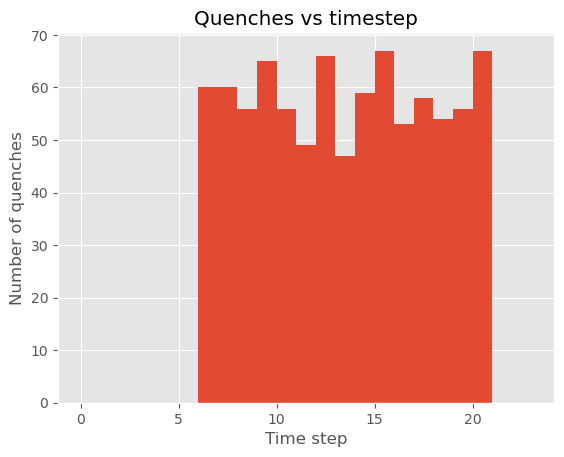

<Figure size 300x200 with 0 Axes>

In [4]:
plt_time = s_time.numpy()
plt_labels = seq_labels.numpy()
bins = np.arange(0,24,1).tolist()

plt.xlabel("Time step")
plt.ylabel("Number of quenches")
plt.title("Quenches vs timestep")
plt.hist(plt_time[new_df.single_quench_label == 1], bins)
plt.figure(figsize=(3,2))
plt.show()

Effettivamente i quench avvengono negli step "centrali"

Ora bisogna valutare le distribuzioni di corrente e vedere come variano in base alla presenza di quench. 
Le feature legate alla corrente che ho usato sono:
* corrente massima
* corrente media
* corrente minima

In [5]:
def double_plot(feature:str, x_label:str, min:float, max:float, step:float):
    bins = np.arange(min, max, step)

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,3))
    ax1.hist(new_df[feature][new_df["single_quench_label"]==0], bins=bins, range=(min, max))
    ax2.hist(new_df[feature][new_df["single_quench_label"]==1], bins=bins, range=(min, max))

    ax1.set_xlabel(x_label)
    ax1.set_ylabel("No-quench events")

    ax2.set_xlabel(x_label) 
    ax2.set_ylabel("Quench events")

    fig.suptitle(f"Quenches vs {x_label}")
    plt.show()

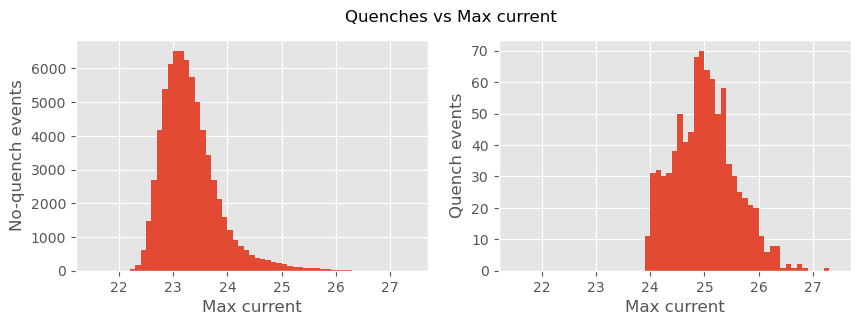

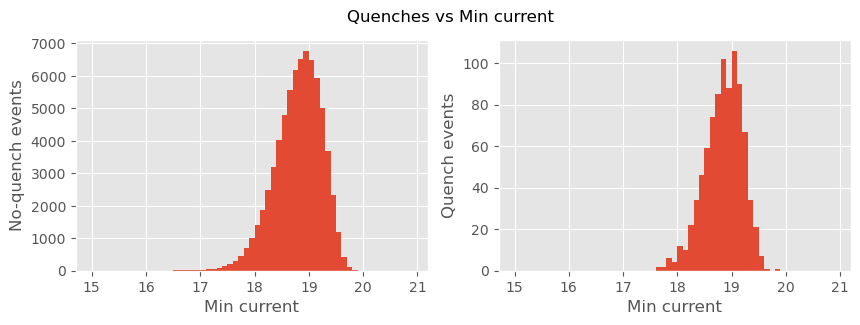

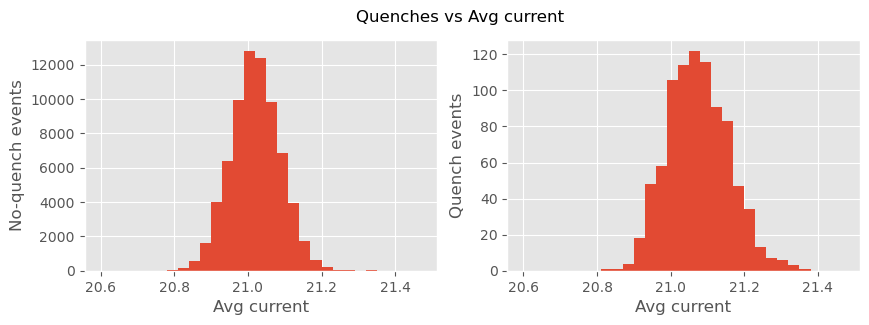

In [6]:
double_plot("max_current", "Max current", 21.5, 27.5, 0.1)
double_plot("min_current", "Min current", 15, 21, 0.1)
double_plot("avg_current", "Avg current", 20.6, 21.5, 0.03)

Considerazioni:
* la corrente massima ha una distribuzione sensibilmente diversa nel caso in cui avvenga il quench rispetto al caso in cui non avvenga
* la corrente minima non presenta variazioni sostanziali nella distribuzione
* la distribuzione di corrente media (con quench) è leggermente shiftata a destra rispetto al caso senza quench. 

### Creazione del dataset

Ora passo alla fase di creazione del dataset. Di base la mia idea è quella di usare, come modello prinicipale, una GNN, pertanto creo un dataset costruito a grafo fully connected.
Il grafo contiene 24 nodi, un nodo corrispondente ad ogni step della sequenza.   
La scelta della GNN risiede nel fatto che risulta essere il modello a più alta espressività e risulta particolarmente comoda per condividere le informazioni tra i vari nodi, così da poterle usare per fare graph classification. 
Ogni nodo contiene 5 features:
* la grid di cavi dopo aver effettuato un reshape. Il reshape deve rispettare la struttura di una sequenza di immagini ```(num_nodes, num_channels, width, height)```. In questo caso ```num_nodes = 24, num_channels = 1``` (non ci sono canali rgb),``` width = height = 15``` per come è costruita la griglia. Questa struttura emerge dalla volontà di voler usare una CNN per l'embedding. Infatti grazie alla CNN si riescono ad apprendere le proprietà globali della grid. Dalle varie prove svolte è emerso che un'operazione chiave nella creazione del modello sia stata la normalizzazione della griglia di corrente. Essa è stata normalizzata rispetto alla media e alla std di tutte le grid di corrente nel dataset. In questo modo ho potuto ottenere migliori risultati nella performance dei modelli. 
* il time step
* corrente massima
* corrente minima, nonostante non sia un parametro predittivo del quench, dopo alcuni tentativi ho notato che la sua presenza non variava le prestazioni del modello quindi l'ho lasciata 
* corrente media

Creo il dataset in modo che sia utilizzabile per due training diversi:
* il primo training è per classificazione binaria (0/1) dei quench.
* il secondo training ha l'obiettivo di addestrare il modello ad imparare il numero di quench degli eventi positivi. Essendo il dataset popolato al 90% in eventi negativi per dare rilevanza agli eventi positivi conviene fare training solo sui positivi. Così è più facile fare inferenza sul numero di quench. 

In [7]:
class CustomDataset(Dataset):
    def __init__(self, path: str):
        
        #ripeto gli step precedenti per la creazione del dataset, questa volta però raggruppo per numero di sequenze
        df = pd.read_json(path)
        df.fillna("nan",inplace=True)
        
        # salvataggio della grid di cavi
        self.img  = torch.Tensor(df["sequence"])
        mean_curr = torch.mean(self.img.flatten(start_dim = 0))
        std_curr  = torch.std(self.img.flatten(start_dim = 0))
        self.img  = (self.img - mean_curr) / std_curr # normalizzazione della corrente     
        
        # salvataggio delle altre features
        self.time = torch.arange(1,25,1).repeat(3000,1).unsqueeze(2).float()
        self.max_current, _ = torch.max(self.img, dim = 2)
        self.min_current, _ = torch.max(self.img, dim = 2)
        self.avg_current = torch.mean(self.img, dim = 2)
        
        # shape matching delle feature così da uniformare il dataset
        self.max_current = self.max_current.unsqueeze(2)
        self.min_current = self.min_current.unsqueeze(2)
        self.avg_current = self.avg_current.unsqueeze(2)
        
        # salvataggio delle truth label delle sequenze
        self.seq_label = torch.Tensor(df["label"]).unsqueeze(1)

        # salvataggio delle label relative alla singola grid di cavi       
        quench = df["quench"]
        single_quench_list = { "id": [],
                               "step": []}

        #stesso loop di prima per assegnare i quench        
        for (i,info) in enumerate(quench):
            if info != "nan": 
                for m_info in info:
                    data = pd.DataFrame(m_info)
                    single_quench_list["id"].append(i)
                    single_quench_list["step"].append(data["step"][0])
        single_quench_label = np.zeros((3000,24))
        for (idx,step) in zip(single_quench_list["id"], single_quench_list["step"]):
            single_quench_label[idx, step] = 1

        self.single_labels    = torch.Tensor(single_quench_label).unsqueeze(2)
        self.num_quenches_old = torch.sum(self.single_labels, dim = 1)
        self.num_quenches     = torch.zeros((3000, int(torch.max(self.num_quenches_old) + 1)) )

        for (i, num) in enumerate(self.num_quenches_old):
            self.num_quenches[i,int(num.item())] = 1
                           
        # creo le liste su cui iterare durante il training                       
        self.graphs = []
        self.labels = []

        #creo i nodi e le rispettive connessioni per un grafo fully connected
        nodes_dict = { "cells": 24}
        
        cell_to_cell_start = torch.arange(24).repeat(24)
        cell_to_cell_end   = torch.repeat_interleave(torch.arange(24), 24)
        
        edges_dict = {('cells','cell_to_cell','cells') : (cell_to_cell_start, cell_to_cell_end)}
        
        #loop di creazione del grafo
        for i in range (len(self.img)):
            g = dgl.heterograph(edges_dict, nodes_dict) #creazione del grafo
            
            # assegnazione delle features ai nodi del grafo  
            g.nodes["cells"].data["img"]   = self.img[i].reshape(24,1,15,15) 
            g.nodes["cells"].data["time"]  = self.time[i]
            g.nodes["cells"].data["max_current"]  = self.max_current[i]
            g.nodes["cells"].data["min_current"]  = self.min_current[i]
            g.nodes["cells"].data["avg_current"]  = self.avg_current[i]         
            self.graphs.append(g) #salvataggio del grafo in una lista
            self.labels.append(self.seq_label[i]) #salvataggio della label in una lista


        gc.collect()
        
    def __getitem__(self, index):
        #quando itero il dataset itero su grafo, label della sequenza, num di quench
        return self.graphs[index], self.labels[index], (self.num_quenches_old[index]-1).long() #eseguo il -1 perchè le categorie per la multi-class classification partono dal numero 0
    
    def __len__(self):
        return len(self.graphs)

dataset = CustomDataset(data_path)

Divido i dataset in train, valid e test dataset. Il training verrà effettuato sul train dataset e le performance durante il training verranno valutate sul valid dataset. Dopo aver estratto il checkpoint dalle prestazioni migliori del modello valuto il modello sul test dataset.

In [8]:
train_size = int(0.6 * len(dataset))
valid_size = int(0.2 * len(dataset))
test_size  = len(dataset) - train_size - valid_size

train_ds, valid_ds, test_ds = random_split(dataset, (train_size, valid_size, test_size))

batch_size = None #ho lasciato volutamente la batch-size = 0 per non complicare il codice della GNN 
dl = DataLoader(dataset, batch_size = batch_size)
train_dl = DataLoader(train_ds, batch_size = batch_size)
valid_dl = DataLoader(valid_ds, batch_size = batch_size)
test_dl  = DataLoader(test_ds , batch_size = batch_size)

Quando si crea una GNN bisogna valutare il modo con cui si vuole effettuare il message passing.
Ho scelto di provare due strategie:
* la prima basata su un message passing fatto con un'architettura di tipo deepset
* la seconda sfruttando il meccanismo di attenzione

Così posso misurare la differenza in performance tra le due architetture. Ho scelto queste due perchè il linea teorica dovrebbero essere quelle che garantiscono prestazioni migliori rispetto ad una somma o media delle hidden representation dei nodi. 

In [9]:
#utilizzo questa semplice rete per fare embedding delle feature monodimensionali come tempo, corrente max, corrente min, corrente media, 
def NodeEmbedding (input_size: int, ouput_size: int):
    embedding_layer = nn.Sequential(nn.Sequential(nn.Linear(1,10),
                                    nn.ReLU(inplace = True)))
    return embedding_layer

#questo oggetto definisce una tipologia di node update della GNN. Questo permette di usare un deep-set per fare message passing
class NodeUpdate (nn.Module):
    def __init__(self, inputsize:int) -> None:
        super().__init__()
        self.phi = nn.Sequential(nn.Linear(inputsize, inputsize), 
                                 nn.ReLU(inplace=True), 
                                 nn.Linear(inputsize, inputsize))
        self.theta = nn.Sequential(nn.Linear(inputsize, inputsize), 
                                   nn.ReLU(inplace=True), 
                                   nn.Linear(inputsize, inputsize))

    def forward(self, nodes):
        hidden  = nodes.mailbox["message"]
        inputs  = self.phi(hidden)
        outputs = self.theta(torch.sum(inputs, dim = 1))
        
        return {"message": outputs}
    
# questo oggetto permette di usare il meccanismo di attenzione per eseguire il message passing della rete. In questo modo 
# la rete può impare a riconoscere i nodi dai quali conviene estrarre informazioni.

class SlotAttention (nn.Module):
    def __init__(self, num_heads: int, hidden_size: int, head_size: int) -> None:
        super().__init__()
        
        self.num_heads   = num_heads
        self.hidden_size = hidden_size
        self.head_size   = head_size
        
        # !!in realtà non ho usato questa rete nel mecccanismo di attenzione ma se la togliessi dovrei ricalcolare il checkpoint del modello!!
        self.phi   = nn.Sequential(nn.Linear(hidden_size, 552), 
                                   nn.ReLU(inplace=True), 
                                   nn.Linear(552, hidden_size))
        # !!in realtà non ho usato questa rete nel mecccanismo di attenzione ma se la togliessi dovrei ricalcolare il checkpoint del modello!!
        self.theta = nn.Sequential(nn.Linear(head_size, head_size), 
                                   nn.ReLU(inplace=True), 
                                   nn.Linear(head_size, hidden_size))
        
        # piuttosto che usare dei linear layer singoli, ho notato che aggiungendo una funzione di attivazione e un altro layer linear le prestazioni 
        # del modello aumentassero
        self.key    = nn.Sequential(nn.Linear(hidden_size, hidden_size, bias=False), nn.ReLU(inplace=True), nn.Linear(hidden_size, head_size)) 
        self.query  = nn.Sequential(nn.Linear(hidden_size, hidden_size, bias=False), nn.ReLU(inplace=True), nn.Linear(hidden_size, head_size))
        self.values = nn.Sequential(nn.Linear(hidden_size, hidden_size, bias=False), nn.ReLU(inplace=True), nn.Linear(hidden_size, head_size))
        self.head_size = head_size      
        
    def edge_function(self, edges):
        attention_weights = torch.sum(edges.src['key']*edges.dst['query'],dim=1) * self.head_size ** -0.5 #calcolo dei pesi 
        attention_weights = F.softmax(attention_weights, dim = 0) 
        values = edges.src['values']
        edges.data['attention_weights'] = attention_weights 

        return {'attention' : attention_weights, 'values' : values} 
    
    def node_update(self, nodes):
        attention_weights = nodes.mailbox['attention'].unsqueeze(2)     
        weighted_sum = torch.sum(attention_weights * nodes.mailbox['values'], dim=1)
        outputs = self.theta(weighted_sum)
        
        return {"message": outputs}

    def forward(self, g):
        nodes_inputs = g.nodes["cells"].data['hidden']

        g.nodes["cells"].data['key']    = self.key(nodes_inputs)
        g.nodes["cells"].data['values'] = self.values(nodes_inputs)
        g.nodes["cells"].data['query']  = self.query(nodes_inputs)        
        g.update_all(self.edge_function, self.node_update, etype = "cell_to_cell") #faccio update del grafo secondo il meccanismo di attenzione

In [10]:
class GNNModel(nn.Module):
    def __init__(self, mode: str, name: str) -> None:
        super().__init__()
        
        self.mode = mode #definisce la tipologia di message passing se tramite deep-set, attention o semplice somma
        self.name = name #definisce il nome con cui salvare il modello
        
        #cnn per encoding delle immagini
        self.img_encoder = nn.Sequential(nn.Conv2d(1, 64, kernel_size = 3, padding = 1),
                                         nn.MaxPool2d(kernel_size = 2, stride = 2),
                                         nn.Conv2d(64, 256, kernel_size = 3, padding = 1),
                                         nn.ReLU(inplace = True),
                                         nn.MaxPool2d(kernel_size = 2, stride = 2),
                                         nn.Conv2d(256, 512, kernel_size = 3, padding = 1),
                                         nn.MaxPool2d(kernel_size = 2, stride = 2),
                                         nn.ReLU(inplace = True),
                                         nn.Flatten(1))
        
        #faccio embedding delle feature monodimensionali
        self.time_encoder        = NodeEmbedding(1,10)
        self.max_current_encoder = NodeEmbedding(1,10)
        self.min_current_encoder = NodeEmbedding(1,10)
        self.avg_current_encoder = NodeEmbedding(1,10)
        
        #esegue il decoding del grafo dopo aver effettuato il message passing        
        self.decoder = nn.Sequential( nn.Linear(1104, 512),
                                      nn.ReLU(inplace = True),
                                      nn.Linear(512, 256),
                                      nn.ReLU(inplace = True),
                                      nn.Linear(256, 128),
                                      nn.ReLU(inplace = True),
                                      nn.Linear(128, 1),
                                      nn.Sigmoid())
        #l'ultimo layer del decoder è la sigmoide in modo da avere una probabilità come output 
        
        #definisco i parametri e oggetti per attention 
        self.head_size   = 100
        self.attention   = SlotAttention(1, 552, 100)
        #definisco il deep-set per il message passing
        self.node_update = NodeUpdate(552)

    def forward(self, g):            
        #creo delle hidden representation per ciascuna delle feature che voglio usare nel training
        h_img  = self.img_encoder(g.nodes["cells"].data["img"])
        h_time = self.time_encoder(g.nodes["cells"].data["time"])
        h_max  = self.max_current_encoder(g.nodes["cells"].data["max_current"])
        h_min  = self.min_current_encoder(g.nodes["cells"].data["min_current"])
        h_avg  = self.avg_current_encoder(g.nodes["cells"].data["avg_current"])
        
        #global hidden representation
        h_tot  = torch.cat((h_img, h_time, h_max, h_min, h_avg), dim = 1)
        g.nodes["cells"].data["hidden"] = h_tot        
        
        #decido quale strategia di condivisione di informazioni dei nodi operare
        if self.mode == "attention":
            self.attention(g)
        elif self.mode == "deep-set":
            for i in range(1):
                g.update_all(fn.copy_u('hidden', 'message'), self.node_update, etype= 'cell_to_cell')       
        else:
            raise TypeError("This operation mode doesn't exist")
        
        #ad ogni nodo concateno l'informazione del message passing
        inputs = torch.cat((g.nodes["cells"].data["hidden"], g.nodes["cells"].data["message"]), dim = 1)
        inputs = torch.sum(inputs, dim = 0)#sommo i vari input 
        
        output = self.decoder(inputs) #calcolo l'output tramite la rete deputata al decoding
        
        return output
                                    

In seguito ho costruito un deepset più semplice per poter confrontare un modello ad alta espressività come la GNN ad un modello più semplice ma non banale. Nel deepset ho usato le stesse reti che ho usato nella GNN per fare encoding e decoding dell'informazione, quindi la variazione sostanziale tra i due modelli è il message passing e la concatenazione dell'informazione ottenuta dal message passing.

In [11]:
class DeepSet(nn.Module):
    def __init__(self, mode:str, name: str) -> None:
        super().__init__()
        self.name = name #definisce la tipologia di message passing se tramite deep-set, attention o semplice somma
        self.mode = mode  #definisce il nome con cui salvare il modello
        
        #cnn per encoding delle immagini
        self.img_encoder = nn.Sequential(nn.Conv2d(1, 64, kernel_size = 3, padding = 1),
                                         nn.MaxPool2d(kernel_size = 2, stride = 2),
                                         nn.Conv2d(64, 256, kernel_size = 3, padding = 1),
                                         nn.ReLU(inplace = True),
                                         nn.MaxPool2d(kernel_size = 2, stride = 2),
                                         nn.Conv2d(256, 512, kernel_size = 3, padding = 1),
                                         nn.MaxPool2d(kernel_size = 2, stride = 2),
                                         nn.ReLU(inplace = True),
                                         nn.Flatten(1))
        
        #faccio embedding delle feature monodimensionali
        self.time_encoder        = NodeEmbedding(1,10)
        self.max_current_encoder = NodeEmbedding(1,10)
        self.min_current_encoder = NodeEmbedding(1,10)
        self.avg_current_encoder = NodeEmbedding(1,10)
        
        self.decoder = nn.Sequential( nn.Linear(512 + 10 * 4, 512),
                                            nn.ReLU(inplace = True),
                                            nn.Linear(512, 256),
                                            nn.ReLU(inplace = True),
                                            nn.Linear(256, 128),
                                            nn.ReLU(inplace = True),
                                            nn.Linear(128, 1),
                                            nn.Sigmoid())
        
        
    def forward(self, g):    
        #creo delle hidden representation per ciascuna delle feature che voglio usare nel training
        h_img  = self.img_encoder(g.nodes["cells"].data["img"])
        h_time = self.time_encoder(g.nodes["cells"].data["time"])
        h_max  = self.max_current_encoder(g.nodes["cells"].data["max_current"])
        h_min  = self.min_current_encoder(g.nodes["cells"].data["min_current"])
        h_avg  = self.avg_current_encoder(g.nodes["cells"].data["avg_current"])
        
        #global hidden representation
        h_tot  = torch.cat((h_img, h_time, h_max, h_min, h_avg), dim = 1)
        
        output = self.decoder(torch.sum(h_tot, dim = 0)) #calcolo l'output tramite la rete deputata al decoding
        
        return output

Ora scrivo tutte le funzioni deputate al calcolo delle metriche. Dopo vari tentativi ho optato per l'utilizzo delle seguenti metriche:
* Accuracy, anche se in questo caso non risulta essere la metrica ideale per valutare la bontà del modello. Essendo presenti nel dataset solo un 10% di positivi, l'accuracy diluisce troppo l'informazione che si ha sulle sequenze in cui è avvenuto il quench.
* True positive rate (TPR), che in questo task, secondo me, risulta essere la metrica più importante per valutare la bontà del modello.  
* True negative rate (TNR), per avere una metrica sul comportamento dei negativi
* Precision, che è indice di quanto spesso il modello predica positivi che sono realmente positivi. 

I modelli danno come output la probabilità che sia avvenuto il quench. Si considera che il quench sia avvenuto se ```p > 0.5```


In [12]:
#creo un oggetto stile struct contenente gli array da usare nei grafici. 
class EvaluationMetrics:
    def __init__(self):
        self.loss_arr       = []
        self.accuracy_arr   = []
        self.tpr_arr        = []
        self.tnr_arr        = []
        self.precision_arr  = []
        self.quench_acc_arr = []
        
class MetricsValues:
    def __init__(self, size):
        #creo i parametri da aggionrare durante il training
        self.acc_num = 0.0
        self.acc_den = 0.0       
        
        self.tpr_num = 0.0
        self.tpr_den = 0.0   
        
        self.tnr_num = 0.0   
        self.tnr_den = 0.0
        
        self.pre_num = 0.0
        self.pre_den = 0.0
        
        self.quench_num = 0.0
        self.quench_den = 0.0
        
        self.epoch_loss = 0.0
        self.acc        = 0.0
        self.tpr        = 0.0
        self.tnr        = 0.0
        self.pre        = 0.0 
        self.quench_acc = 0.0
        self.node_acc   = 0.0
        
        self.global_node_acc = 0.0
        self.size = 0.0 
        
    def Process(self, mode: str) -> None:
        self.mode = mode
        self.epoch_loss = self.epoch_loss / self.size #normalizzo la loss al numero di sequenze nel dataset così da poter fare un confronto equo
        
        if mode == "task2":
            # nel caso del secondo task del progetto mi serve solamente l'accuracy del numero di quench predetti
            self.quench_acc = self.quench_num / self.quench_den
        else:
            self.acc = self.acc_num / self.acc_den   

            #talvolta il denominatore nel calcolo risulta essere zero, quindi ho usato la struttura try and error
            try:
                self.tpr = self.tpr_num / self.tpr_den
            except:
                self.tpr = -1
                
            try:
                self.pre = self.pre_num / self.pre_den
            except:
                self.pre = -1
                
            try:
                self.tnr = self.tnr_num / self.tnr_den
            except:
                self.tnr = -1
    
    def FillArr(self, metrics_arr) -> None:
        #riempimento degli array
        metrics_arr.loss_arr.append(self.epoch_loss)
        metrics_arr.accuracy_arr.append(self.acc)
        metrics_arr.tpr_arr.append(self.tpr)
        metrics_arr.tnr_arr.append(self.tnr)
        metrics_arr.precision_arr.append(self.pre) 
        metrics_arr.quench_acc_arr.append(self.quench_acc)
        
    def Print(self):
        #metodo di controllo
        print(self.tpr_num)
        print(self.tpr_den) 

#funzione da usare per monitorare il training
def PrintValues(epoch, train_values, valid_values, mode) -> None:
    if mode == "task1":
        print(f"""------------------------------------------------------------------------------------------
                    Epoch: {epoch} 
                    Training loss:     {train_values.epoch_loss:.4f}  Validation loss:   {valid_values.epoch_loss:.4f} 
                    Train accuracy:    {train_values.acc:.4f}  Valid accuracy:    {valid_values.acc:.4f}
                    Train TPR:         {train_values.tpr:.4f}  Valid TPR:         {valid_values.tpr:.4f}
                    Train TNR:         {train_values.tnr:.4f}  Valid TNR:         {valid_values.tnr:.4f}
                    Train precision:   {train_values.pre:.4f}  Valid precision:   {valid_values.pre:.4f}""")
    else:
        print(f"""------------------------------------------------------------------------------------------
                    Epoch: {epoch} 
                    Training loss   :  {train_values.epoch_loss:.4f}  Validation loss :  {valid_values.epoch_loss:.4f} 
                    Train q-accuracy:  {train_values.quench_acc:.4f}  Valid q-accuracy:  {valid_values.quench_acc:.4f}""")

#calcolo dei termini da usare per calcolare accuracy, tpr, tnr e precision durante il training
def evaluate(values, g_out, graph_label):
    pred = torch.tensor([0 if y_pred < 0.5 else 1 for y_pred in g_out]).to(device) #imposto la treshold a 0.5 per fare classificazione
    pred = pred.unsqueeze(1)
    checks = torch.eq(pred, graph_label)
    acc    = torch.sum(checks)
    
    values.size += 1

    true_positive  = torch.sum(torch.logical_and(pred, graph_label)) 
    true_negative  = torch.sum(torch.logical_and(torch.logical_not(pred), torch.logical_not(graph_label))) 
    false_negative = torch.sum(torch.logical_and(torch.logical_not(pred), graph_label)) 
    false_positive = torch.sum(torch.logical_and(pred, torch.logical_not(graph_label))) 
     
    values.acc_num += acc.item()
    values.acc_den += 1
    
    values.tpr_num += true_positive.item()
    values.tpr_den += (true_positive.item() + false_negative.item())

    values.tnr_num += true_negative.item()
    values.tnr_den += (true_negative.item() + false_positive.item())

    values.pre_num += true_positive.item()
    values.pre_den += (true_positive.item() + false_positive.item())

#plot dei grafici a fine training    
def PlotMetrics(n_epochs, train_metrics, valid_metrics, name, model_mode, mode = "task1",):
    epochs = list(range(n_epochs))
    
    if mode == "task1":
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,10))
        ax1.plot(epochs, train_metrics.loss_arr, label = "training")
        ax1.plot(epochs, valid_metrics.loss_arr, label = "valid")
        ax1.legend()
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("BCE loss value")

        ax2.plot(epochs, train_metrics.accuracy_arr, label = "training")
        ax2.plot(epochs, valid_metrics.accuracy_arr, label = "valid")
        ax2.legend()
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Accuracy")

        ax3.plot(epochs, train_metrics.tpr_arr, label = "training")
        ax3.plot(epochs, valid_metrics.tpr_arr, label = "valid")
        ax3.legend()
        ax3.set_xlabel("Epoch")
        ax3.set_ylabel("TPR")

        ax4.plot(epochs, train_metrics.precision_arr, label = "training")
        ax4.plot(epochs, valid_metrics.precision_arr, label = "valid")
        ax4.legend()
        ax4.set_xlabel("Epoch")
        ax4.set_ylabel("Precision")

        plt.show()
        fig.savefig(f"img/{name}_{model_mode}.png")
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 5))
        ax1.plot(epochs, train_metrics.loss_arr, label = "training")
        ax1.plot(epochs, valid_metrics.loss_arr, label = "valid")
        ax1.legend()
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Cross-entropy loss value")

        ax2.plot(epochs, train_metrics.quench_acc_arr, label = "training")
        ax2.plot(epochs, valid_metrics.quench_acc_arr, label = "valid")
        ax2.legend()
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Quench accuracy")
        fig.savefig(f"img/{name}_{model_mode}.png")

In [13]:
#dovendo ripetere il training per più modelli conviene creare una funzione per il training
def training_phase(model, loss_func, optimizer, epochs, train_dl, valid_dl, mode = "task1"):
    #se non esiste, creo la cartella per il salvataggio dei checkpoint del modello
    if not os.path.exists(f"{model.name}_{model.mode}"):
        os.makedirs(f"{model.name}_{model.mode}")
        
    if not os.path.exists("img"):
        os.makedirs("img")
        
    #definisco gli array di metriche
    train_metrics = EvaluationMetrics();
    valid_metrics = EvaluationMetrics();
    
    #loop sul numero di epoche
    for epoch in tqdm(range(1, epochs+1)):
        train_values = MetricsValues(train_size)
        model.train() # metto il modello in modalità training
        for g, graph_label, num_quenches  in train_dl :
            if mode != "task1":
                if graph_label == 0:
                    continue
                
            g = g.to(device) #facendo training su gpu sposto il dataset sul device selezionato (nel mio caso gpu)
            g_out = model(g) #calcolo la predizione del modello   
                
            #agisco in base al task che devo compiere
            if (mode == "task1"):
                #quench classification
                graph_label = graph_label.to(device) #sposto la label della sequenza su gpu
                loss = loss_func(g_out, graph_label) #calcolo la loss
            else:
                #quench number inference
                num_quenches = num_quenches.to(device) #sposto le categorie di quench su gpu
                loss = loss_func(g_out, num_quenches)  #calcolo la loss
        
            optimizer.zero_grad() #reinizializzo il gradiente 
            loss.backward()       #calcolo il gradiente
            optimizer.step()      #update dei parametri dell'ottimizzatore  

            train_values.epoch_loss += loss.detach().item() #salvataggio loss

            #evaluation dei parametri a seconda del task
            if (mode == "task1"):
                evaluate(train_values, g_out, graph_label)
            else:
                evaluate(train_values, g_out, num_quenches)

        train_values.Process(mode) #calcolo delle metriche
        train_values.FillArr(train_metrics) #riempimento degli array
                
        model.eval() #metto il modello in evaluation mode per stimare le metriche sul validation dataset
        
        #ora il loop è analogo al precedente ma senza gli step di ottimizzazione
        
        valid_values = MetricsValues(valid_size)
        for g, graph_label, num_quenches  in valid_dl:
            if mode != "task1":
                if graph_label == 0:
                    continue
                
            g = g.to(device)
            g_out = model(g)   
            
            if (mode == "task1"):
                graph_label = graph_label.to(device)
                loss = loss_func(g_out, graph_label)
            else:
                num_quenches = num_quenches.to(device)
                loss = loss_func(g_out, num_quenches) 
            
            valid_values.epoch_loss += loss.detach().item()
            
            if (mode == "task1"):
                evaluate(valid_values, g_out, graph_label)
            else:
                evaluate(valid_values, g_out, num_quenches)
            
        valid_values.Process(mode)
        valid_values.FillArr(valid_metrics)

        PrintValues(epoch, train_values, valid_values, mode)
        torch.save(model.state_dict(), f"{model.name}_{model.mode}/{model.name}_{epoch}") # salvo il modello per agevolare la fase di test
        
    PlotMetrics(epochs, train_metrics, valid_metrics, model.name, model.mode, mode) #alla fine del loop plotto le metriche in funzione del numero di epoche    

Per fare classificazione binaria risulta comodo usare la binary cross entropy (BCE) loss. In questo caso pytorch mette a disposizione due loss simili ma differenti se si vuole usare la BCE:
* ```BCELoss``` che vuole in ingresso una probabilità,
* ```BCEWithLogitLoss``` che vuole in ingresso una logit,

Avendo scelto come ultimo layer dei modelli una sigmoide ho optato per la ```BCELoss```

L'ottimizzatore che ho scelto è stato AdamW viste le sue elevate prestazioni.

Ho fatto diverse prove con diversi learning rate e la scelta più indicata è stato ```lr = 10e-7```. Valori più alti rendevano l'andamento della loss molto meno smooth. In questo modo il modello ha impiegato più tempo per andare a convergenza e per questo ho incrementato il numero di epoche. Il numero di epoche è stato scelto in base al modello sulla base di svariati tentativi.

In [14]:
model1    = GNNModel("deep-set", "gnn").to(device)
loss_func = nn.BCELoss()
optimizer = optim.AdamW(model1.parameters(), lr = 10e-7)
n_epochs  = 40

#training_phase(model1, loss_func, optimizer, n_epochs, train_dl, valid_dl)

In [15]:
model2    = GNNModel("attention", "gnn").to(device)
loss_func = nn.BCELoss()
optimizer = optim.AdamW(model2.parameters(), lr = 10e-7)
n_epochs  = 50

#training_phase(model2, loss_func, optimizer, n_epochs, train_dl, valid_dl)

In [16]:
model3    = DeepSet("", "deep-set").to(device)
loss_func = nn.BCELoss()
optimizer = optim.AdamW(model3.parameters(), lr = 10e-7)
n_epochs  = 50

#training_phase(model3, loss_func, optimizer, n_epochs, train_dl, valid_dl)

#### Conclusioni

Per trarre le conclussioni scelgo il modello all'iterazione in cui la valid-loss ha raggiunto il minimo e lo valuto sul dataset di test.

In [17]:
#dichiaro nuovamente i modelli
gnn_attention = GNNModel("attention", "gnn")
gnn_deepset   = GNNModel("deep-set", "gnn")
deepset       = DeepSet("deep-set", "deep-set")

#faccio il load dei pesi dal checkpoint salvato
gnn_attention.load_state_dict(torch.load("weights/gnn_attention/gnn_20"))
gnn_deepset.load_state_dict(torch.load("weights/gnn_deep-set/gnn_18"))
deepset.load_state_dict(torch.load("weights/deep-set_/deep-set_35"))

#metto i modelli in modalità di evaluation
gnn_attention.eval()
gnn_deepset.eval()
deepset.eval()

#creo gli array da riempire con le label truth e predicted
test_label = []
gnn_attention_pred = []
gnn_deepset_pred   = []
deepset_pred       = [] 

#creo gli array relativi ai modelli e alle predizioni per agevolare l'evaluation
model_list = [gnn_attention, gnn_deepset, deepset] #questo con i modelli precaricati 
arr_list   = [gnn_attention_pred, gnn_deepset_pred, deepset_pred]
arr_name   = ["gnn_attention", "gnn_deepset", "deepset"]

#loop di evaluation
for g, label, num_quench in test_dl:
    test_label.append(int(label.item()))
    for (i, model) in enumerate(model_list):
        out = model(g).item()
        if out < 0.5:
            arr_list[i].append(0)
        else:
            arr_list[i].append(1)       

Per valutare una classificazione binaria creo una confusion matrix con le label originali e le label predette, analizzando Accuracy, TPR, TNR e Precision.

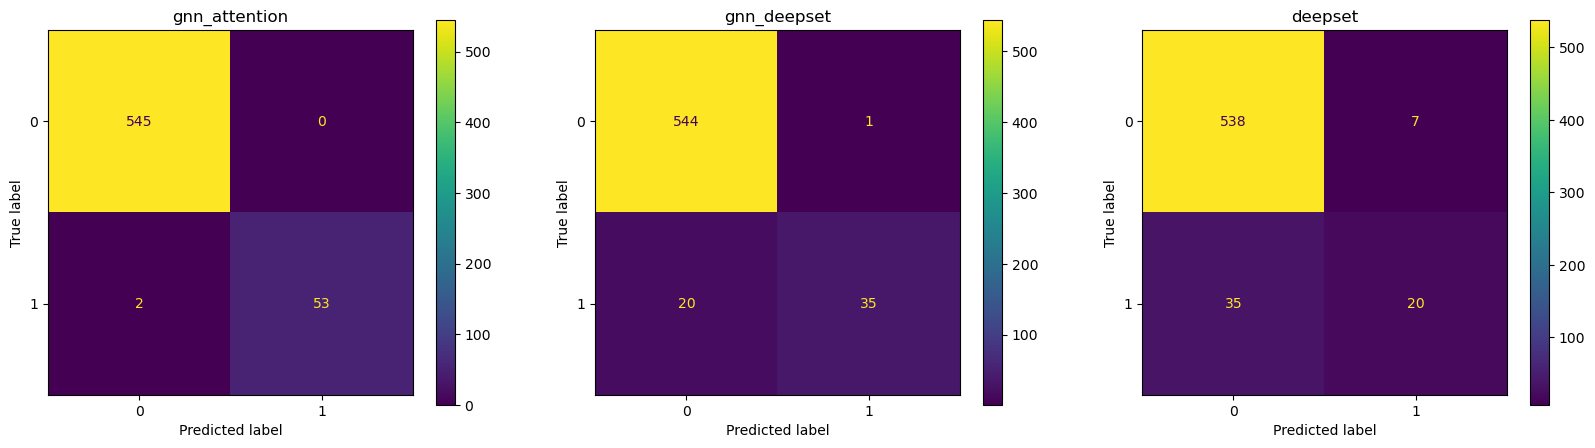

In [18]:
plt.style.use('default')
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

cm1 = confusion_matrix(test_label, arr_list[0])
ConfusionMatrixDisplay(cm1).plot(ax = ax1)
ax1.set_title(arr_name[0])

cm2 = confusion_matrix(test_label, arr_list[1])
ConfusionMatrixDisplay(cm2).plot(ax = ax2)
ax2.set_title(arr_name[1])

cm3 = confusion_matrix(test_label, arr_list[2])
ConfusionMatrixDisplay(cm3).plot(ax = ax3)
ax3.set_title(arr_name[2])
plt.show()

In [19]:
 #estraggo le stesse metriche di prima dalla confusion matrix
def extract_metrics(cm, title: str):
    (tn, fp, fn, tp) = cm.ravel()
    acc = (tp + tn) / (tn + fp + fn + tp)
    pre = (tp) / (tp + fp)
    tpr = (tp) / (tp + fn)
    tnr = (tn) / (tn + fp)
    
    print(f"{title}: \n")
    print(f"""Accuracy : {acc:.4f} \nPrecision: {pre:.4f} \nTPR      : {tpr:.4f} \nTNR      : {tnr:.4f}\n""")

extract_metrics(cm1, arr_name[0])
extract_metrics(cm2, arr_name[1])
extract_metrics(cm3, arr_name[2])

    
    

gnn_attention: 

Accuracy : 0.9967 
Precision: 1.0000 
TPR      : 0.9636 
TNR      : 1.0000

gnn_deepset: 

Accuracy : 0.9650 
Precision: 0.9722 
TPR      : 0.6364 
TNR      : 0.9982

deepset: 

Accuracy : 0.9300 
Precision: 0.7407 
TPR      : 0.3636 
TNR      : 0.9872



In conclusione si vede come l'accuracy sia un parametro poco affidabile per valutare la bontà del modello. Infatti guardando anche i grafici del training si vede come sin dalle prime epoche sia facile ottenere un'accuracy elevata ma uno scarso TPR. Quindi il parametro chiave per giudicare la bontà del modello risulta essere il TPR. Si vede come il TPR maggiore sia ottenuto dal modello basato su GNN+attention, confermando la maggiore potenza espressiva di questo tipo di modelli. Successivamente il modello gnn+deep-set riesca comunque ad avere una buona tpr seppur inferiore al modello con attention. 
L'espressività delle GNN risulta essere messa in evidenza dalle prestazioni del modello con DeepSet. Infatti le GNN e il DeepSet possiedono lo stesso tipo di reti deputate all'encoding e al decoding. Tuttavia la reale differenza tra i due modelli è il message passing che ha permesso di raggiungere prestazioni più elevate.
La precision risulta essere pari a 1 nel caso del modello GNN+attention. Quindi tutti i quench che vengono predetti sono realmente avvenuti. Molto elevata la precision del modello GNN+deepset. 
Visto l'elevato TNR tutti e tre i modelli sono abili nel distinguere le sequenze in cui non è avvenuto alcun quench. 


## Task 2 - Infer the number of quenches

Per assolvere questo task ho pensato di numerare il numero di quench in ciascuna sequenza. All'interno del dataset avvengono al massimo 11 quench per sequenza. Pertanto ho deciso di usare un modello di classificazione che mi potesse assegnare alla sequenza una categoria da 1 a 11. Ho deciso di fare training solamente sulla parte di dataset in cui avviene almeno un quench per sequenza. Provando con l'intero dataset ho ottenuto prestazioni inferiori, probabilmente dovute al fatto che circa il 90% del dataset originale contiene sequenze in cui non avviene nessun quench. 

In [20]:
def evaluate(values, output, num_quench, mode = None, pred_arr = None, true_arr = None):
    output = F.softmax(output.flatten(), dim=0)
    pred_n_quench = torch.argmax(output, dim = 0)
    
    if mode == "fill":
        pred_arr.append(pred_n_quench.item())
        true_arr.append(num_quench.item())
     
    quench_check  = pred_n_quench == (num_quench)    
    values.quench_num += torch.sum(quench_check).item()
    values.quench_den += 1
    values.size += 1
    
    

Il modello è analogo a prima con qualche piccola variazione. Dovendo fare mutliclass classification il layer finale con la sigmoide è stato sotituito da un layer lineare la cui dimensione è pari al numero di classi (11). L'ideale per fare multiclass classification è usare la cross entropy loss.
Successivamente l'output del modello verrà passato ad una softmax, rendendo il vettore di output un vettore di probabilità per ogni classe.
Il criterio con cui si assegna il numero di quench è la probabilità massima di una data categoria. 

In [21]:

class GNNModel_v2(nn.Module):
    def __init__(self, mode: str, name: str) -> None:
        super().__init__()
        
        self.mode = mode
        self.name = name
        self.img_encoder = nn.Sequential(nn.Conv2d(1, 128, kernel_size = 3, padding = 1),
                                         nn.MaxPool2d(kernel_size = 2, stride = 2),
                                         nn.Conv2d(128, 512, kernel_size = 3, padding = 1),
                                         nn.ReLU(inplace = True),
                                         nn.MaxPool2d(kernel_size = 2, stride = 2),
                                         nn.Conv2d(512, 1024, kernel_size = 3, padding = 1),
                                         nn.MaxPool2d(kernel_size = 2, stride = 2),
                                         nn.ReLU(inplace = True),
                                         nn.Flatten(1))

        self.time_encoder        = NodeEmbedding(1,10)
        self.max_current_encoder = NodeEmbedding(1,10)
        self.min_current_encoder = NodeEmbedding(1,10)
        self.avg_current_encoder = NodeEmbedding(1,10)
        
        self.decoder = nn.Sequential(nn.Linear(2128, 1024),
                                     nn.ReLU(inplace = True),
                                     nn.Linear(1024, 512),
                                     nn.ReLU(inplace = True),
                                     nn.Linear(512, 128),
                                     nn.ReLU(inplace = True),
                                     nn.Linear(128, 11))
        self.head_size   = 3000
        self.attention   = SlotAttention(1, 1064, self.head_size)
        self.node_update = NodeUpdate(1064)

    def forward(self, g):            
        h_img  = self.img_encoder(g.nodes["cells"].data["img"])
        h_time = self.time_encoder(g.nodes["cells"].data["time"])
        h_max  = self.max_current_encoder(g.nodes["cells"].data["max_current"])
        h_min  = self.min_current_encoder(g.nodes["cells"].data["min_current"])
        h_avg  = self.avg_current_encoder(g.nodes["cells"].data["avg_current"])
        
        #global hidden representation
        h_tot  = torch.cat((h_img, h_time, h_max, h_min, h_avg), dim = 1)
        g.nodes["cells"].data["hidden"] = h_tot        
        
        if self.mode == "attention":
            self.attention(g)
        elif self.mode == "simple-sum":
            for i in range(1):
                g.update_all(fn.copy_u('hidden', 'message'), fn.sum('message', 'message'), etype= 'cell_to_cell')
        elif self.mode == "deep-set":
            for i in range(1):
                g.update_all(fn.copy_u('hidden', 'message'), self.node_update, etype= 'cell_to_cell') #posso mettere un deepset nel message
        else:
            raise TypeError("This operation mode doesn't exist")
        
        inputs = torch.cat((g.nodes["cells"].data["hidden"], g.nodes["cells"].data["message"]), dim = 1)
        inputs = torch.sum(inputs, dim = 0)

        
        output  = self.decoder(inputs).unsqueeze(0)
        
        return output

Analogamente al task precedente costruisco un deepset così da poter fare un confronto con la GNN

In [22]:
class DeepSet_v2(nn.Module):
    def __init__(self, mode:str, name: str) -> None:
        super().__init__()
        self.name = name
        self.mode = mode
        self.img_encoder = nn.Sequential(nn.Conv2d(1, 64, kernel_size = 3, padding = 1),
                                         nn.MaxPool2d(kernel_size = 2, stride = 2),
                                         nn.Conv2d(64, 256, kernel_size = 3, padding = 1),
                                         nn.ReLU(inplace = True),
                                         nn.MaxPool2d(kernel_size = 2, stride = 2),
                                         nn.Conv2d(256, 512, kernel_size = 3, padding = 1),
                                         nn.MaxPool2d(kernel_size = 2, stride = 2),
                                         nn.ReLU(inplace = True),
                                         nn.Flatten(1))
        
        self.time_encoder        = NodeEmbedding(1,10)
        self.max_current_encoder = NodeEmbedding(1,10)
        self.min_current_encoder = NodeEmbedding(1,10)
        self.avg_current_encoder = NodeEmbedding(1,10)
        
        self.decoder = nn.Sequential( nn.Linear(512 + 10 * 4, 512),
                                            nn.ReLU(inplace = True),
                                            nn.Linear(512, 256),
                                            nn.ReLU(inplace = True),
                                            nn.Linear(256, 128),
                                            nn.ReLU(inplace = True),
                                            nn.Linear(128, 11))
        
    def forward(self, g):            
        h_img  = self.img_encoder(g.nodes["cells"].data["img"])
        h_time = self.time_encoder(g.nodes["cells"].data["time"])
        h_max  = self.max_current_encoder(g.nodes["cells"].data["max_current"])
        h_min  = self.min_current_encoder(g.nodes["cells"].data["min_current"])
        h_avg  = self.avg_current_encoder(g.nodes["cells"].data["avg_current"])
        h_tot  = torch.cat((h_img, h_time, h_max, h_min, h_avg), dim = 1)
        
        output = self.decoder(torch.sum(h_tot, dim = 0)).unsqueeze(0)
        
        return output

L'ottimizzatore è sempre AdamW  e il learning rate è stato scelto secondo le logiche del task precedente

In [23]:
model = GNNModel_v2("attention", "gnnv2").to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 10e-7)
n_epochs  = 80
#training_phase(model, loss_func, optimizer, n_epochs, train_dl, valid_dl, "task2")

In [24]:
model = GNNModel_v2("deep-set", "gnnv2").to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 10e-7)
n_epochs  = 70

#training_phase(model, loss_func, optimizer, n_epochs, train_dl, valid_dl, "task2")


In [25]:
model = DeepSet_v2("", "deep-set_v2").to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 10e-7)
n_epochs  = 70
#training_phase(model, loss_func, optimizer, n_epochs, train_dl, valid_dl, "task2")

#### Conclusioni

Come prima ho scelto per ciascun modello il punto corrispondende al minimo (o allo stallo) della validation loss.   

In [26]:
#dichiarazione dei modelli
gnn_attention2 = GNNModel_v2("attention", "gnn")
gnn_deepset2   = GNNModel_v2("deep-set", "gnn")
deepset2       = DeepSet_v2("deep-set", "deep-set")

#load dei pesi del checkpoint scelto
gnn_attention2.load_state_dict(torch.load("weights/gnnv2_attention/gnnv2_70"))
gnn_deepset2.load_state_dict(torch.load("weights/gnnv2_deep-set/gnnv2_30"))
deepset2.load_state_dict(torch.load("weights/deep-set_v2_/deep-set_v2_70"))

#metto i modelli in evaluation mode
gnn_attention2.eval()
gnn_deepset2.eval()
deepset2.eval()

#dichiaro gli array in cui salvare le label truth e predicted
test_label2 = []
gnn_attention_pred2 = []
gnn_deepset_pred2   = []
deepset_pred2       = [] 

#sfrutto gli array per agevolare la fase di evaluation
model_list2 = [gnn_attention2, gnn_deepset2, deepset2]
arr_list2   = [gnn_attention_pred2, gnn_deepset_pred2, deepset_pred2]
arr_name2   = ["gnn_attention_v2", "gnn_deepset_v2", "deepset_pred_v2"]

for g, label, num_quench in valid_dl:
    if label != 1:
        continue
    test_label2.append(int(num_quench.item()))
    for (i, model) in enumerate(model_list2):
        out = model(g)
        out = F.softmax(out.flatten(), dim=0)
        pred_n_quench = torch.argmax(out, dim = 0)
        
        arr_list2[i].append(int(pred_n_quench.item()))

Uso sempre la confusion matrix per valutare i risultati. 

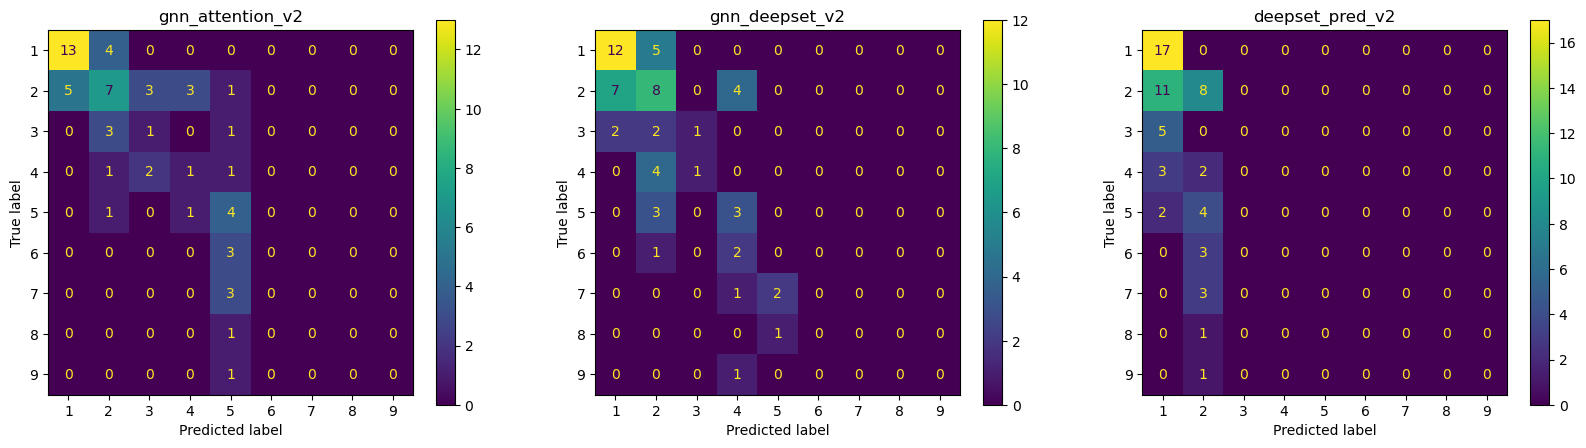

In [27]:
max_quench = max(test_label2)
labels = [f"{x}" for x in range (1,max_quench+2)]

plt.style.use('default')
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

cm1 = confusion_matrix(test_label2, arr_list2[0])
ConfusionMatrixDisplay(cm1, display_labels = labels).plot(ax = ax1)
ax1.set_title(arr_name2[0])

cm2 = confusion_matrix(test_label2, arr_list2[1])
ConfusionMatrixDisplay(cm2, display_labels = labels).plot(ax = ax2)
ax2.set_title(arr_name2[1])

cm3 = confusion_matrix(test_label2, arr_list2[2])
ConfusionMatrixDisplay(cm3, display_labels = labels).plot(ax = ax3)
ax3.set_title(arr_name2[2])
plt.show()

In [28]:
def extract_metrics(cm, title: str):
    arr  = np.array(cm.ravel())
    size = int(np.sqrt(len(arr)))
    arr = arr.reshape((size, size)) #faccio reshape per poter calcolare facilmente gli elementi sulla diagonale
    num = 0.0
    den = sum(cm.ravel()) #calcolo gli eventi totali nel dataset
    #gli elementi sulla diagonale sono quelli corretti, quindi li sommo tra loro e calcolo il numeratore
    for i in range(size):
        num += arr[i,i]
    
    accuracy = num / den
    print(f"{title}: \nAccuracy :{accuracy} \n")    
    
    
extract_metrics(cm1, arr_name2[0])
extract_metrics(cm2, arr_name2[1])
extract_metrics(cm3, arr_name2[2])

gnn_attention_v2: 
Accuracy :0.43333333333333335 

gnn_deepset_v2: 
Accuracy :0.35 

deepset_pred_v2: 
Accuracy :0.4166666666666667 



Essendo una classificazione a multiclasse estraggo solamente l'accuracy.

Anche per questo task il modello gnn+attention presenta l'accuracy migliore. La gnn+deepset in questo caso ottiene risultati inferiori al deepset. Questo in realtà potrebbe anche essere dovuto ad una poca statistica nel dataset di training e test.

Dalle metriche ottenute è emerso che probabilmente la strategia scelta non è stata quella ottimale. L'accuracy raggiunta è superiore rispetto a quella che si raggiungerebbe con una random guess (~ 1/9). Tuttavia non si è riuscito a raggiungere un accuracy sufficientemente elevata.

Problemi e possibili soluzioni:
* piuttosto che considerare il numero di quench come una feature relativa al grafo avrei potuto predire la presenza di quench sul singolo nodo. In questa maniera avrei potuto predire il numero di quench come somma degli eventi di quench avvenuti nei nodi del grafo. 
* sfruttando la strategia menzionata sopra si riuscirebbe a sfruttare tutto il dataset. Infatti un problema di questo approccio è che ho dovuto fare un secondo training su un dataset filtrato per poter ottenere dei nuovi risultati. Nell'altro modo riuscirei ad avere una statistica elevata e a svolgere entrambi i task con un singolo modello. Dividendo il dataset ulteriormente in train, validation e test dataset riduco ulteriorement la statistica sui cui effettuo il training e calcolo le metriche. 